# 기차 대차 이상 소음원 탐지 모델

In [1]:
# Author jhCOR

### 드라이브 마운트 /  라이브러리 임포트 / 라이브러리 설치

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 12.5 MB/s eta 0:00:00


In [4]:
import torchaudio.functional as F
import torch.nn as nn
import torchaudio
import torch

import pandas as pd
import numpy as np
import librosa
import glob
import os
import re
from tqdm import tqdm
import random
import copy

import matplotlib.pyplot as plt
from datetime import datetime
from pathlib import Path
import torch.optim as optim
from torch.utils.data import Dataset
from collections.abc import Iterable
from torch.utils.data import DataLoader, random_split

from torchvision.models import resnet18

### 시드 고정 / device설정 / 실험 세팅 값 설정

In [5]:
print("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
    print('Current cuda device:', torch.cuda.current_device())
    print('Count of using GPUs:', torch.cuda.device_count())

#################

config = {'sr' : 25600, 'device':device, 'n_mels':80, 'core':os.cpu_count(), "train_ratio":0.6,
           "valid_ratio":0.2, "test_ratio":0.2, "path":"./best_model.pt", "seed": 42}

#################

dirPath = "/content/drive/MyDrive/Artificial_Intelligence/ai_data/기차대차소음/S206_wav"
csvPath = "/content/drive/MyDrive/Artificial_Intelligence/ai_data/기차대차소음/metadata.csv"
othersourcePath = "/content/drive/MyDrive/Artificial_Intelligence/ai_data/MTAT_SMALL"
model_save_path = "./best_model.pt"

cuda
Current cuda device: 0
Count of using GPUs: 1


In [6]:
def restrict_seed(seed):
    print("시드 고정: ", seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def isIterable(target):
    return True if isinstance(target, Iterable) else False

def plot_spectrogram(spectrogram, title=None, ylabel="freq_bin"):
    plt.clf()
    fig, axs = plt.subplots(1, 1, figsize=(10, 4))
    axs.set_title(title or "Spectrogram")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(spectrogram), origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

In [7]:
restrict_seed(config['seed'])
print(config)

시드 고정:  42
{'sr': 25600, 'device': 'cuda', 'n_mels': 80, 'core': 8, 'train_ratio': 0.6, 'valid_ratio': 0.2, 'test_ratio': 0.2, 'path': './best_model.pt', 'seed': 42}


### 데이터셋 정의

In [8]:
class soundDataset(Dataset):
    def __init__(self, dir_path, csv_path, mode="train", config=None, other_sound_path=None, mixSoundRatio=0):
        self.mel_converter = torchaudio.transforms.MelSpectrogram(sample_rate=config['sr'], n_mels=config['n_mels'])
        self.db_converter = torchaudio.transforms.AmplitudeToDB()
        self.dir = dir_path
        self.mixSoundRatio = mixSoundRatio
        self.config = config

        assert other_sound_path is not None, "it must be filled"
        self.other_sound_dir = other_sound_path

        colume_list = ['title',  'Car_type', 'Horn', 'Position', 'S206_position','Length', 'Car_num', 'path']

        metaData = pd.read_csv(csv_path)
        metaData = metaData[colume_list]
        metaData = metaData.sort_values(by="Car_type")
        metaData['label'] = metaData['Horn'].apply(lambda x: 1 if x == "Yes" else 0)
        metaData['Position'] = metaData['Position'].fillna(-1)

        self.meta = metaData
        self.meta = self._check_all_file_exist()
        self.meta['length'] = self._check_all_file_size()
        display(self.meta)
        print("Horn Yes 개수", len(self.meta[self.meta['Horn']=="Yes" ]), "Horn No 개수", len(self.meta[self.meta['Horn']=="No" ]))

    def _get_other_sound(self):
    # 병합할 다른 소리 파일 가져오기
        _meta = pd.read_csv( self.other_sound_dir + "/meta.csv", index_col=[0] )

        _meta = _meta['mp3_path']
        path = _meta.iloc[random.randrange(1,len(_meta))]

        waveform, sample_rate = torchaudio.load( self.other_sound_dir / Path(str(path)).with_suffix('.mp3'))
        audio_sample = F.resample(waveform[0], sample_rate, self.config['sr'], lowpass_filter_width=6)
        return audio_sample

    def _check_all_file_exist(self):
    # 파일-음원 매칭을 체크하여 소리 파일이 없는 경우 제외
        for i in range(len(self.meta['path'])):
            path = self.meta['path'].iloc[i]
            if not os.path.exists(self.dir / Path(path).with_suffix('.wav')):
                meata_data = self.meta [self.meta['path']!=path]
                return meata_data

    def _check_all_file_size(self):

        length_list = []
        for i in range(len(self.meta['path'])):
            waveform, sample_rate = torchaudio.load(self.dir / Path(self.meta['path'].iloc[i]).with_suffix('.wav'))
            audio_sample = F.resample(waveform[0], sample_rate, self.config['sr'], lowpass_filter_width=6)

            length_list.append(len(audio_sample))
        return length_list

    def minmaxScaler(self, data):
    # 정규화 수행
        data_min, data_max = data.min(), data.max()
        new_lower, new_upper = -1, 1
        scaled_data = (data - data_min)/(data_max - data_min)*(new_upper - new_lower) + new_lower
        return scaled_data

    def mixOtherSound(self, audio_sample, mix_rate=1.0):
    # 시험 데이터를 실 데이터로 전이시키는 함수
        other_sound = self._get_other_sound()
        if len(other_sound) > len(audio_sample):
            other_sound = other_sound[:len(audio_sample)]
        else:
            other_sound = other_sound[:len(audio_sample)]
            front = int( (len(audio_sample) - len(other_sound)) / 4 )
            back = (len(audio_sample) - len(other_sound)) - front
            other_sound = nn.functional.pad(other_sound, (front, back) , 'constant', value=0)

        scaled_audio_data = self.minmaxScaler(audio_sample)
        scaled_other_data = self.minmaxScaler(other_sound)

        audio_sample = scaled_audio_data + (scaled_other_data*mix_rate)

        return audio_sample

    def __getitem__(self, idx):
        row =  self.meta.iloc[idx]
        path = row['path']
        label = row['label']

        waveform, sample_rate = torchaudio.load(self.dir / Path(path).with_suffix('.wav'))
        audio_sample = F.resample(waveform[0], sample_rate, self.config['sr'], lowpass_filter_width=6)

        if self.mixSoundRatio > 0:
            audio_sample = self.mixOtherSound(audio_sample, mix_rate=self.mixSoundRatio)

        feature = self.db_converter(self.mel_converter(audio_sample))
        label = nn.functional.one_hot(torch.tensor(label), num_classes=2)

        return feature, label

    def __len__(self):
        return len(self.meta)

def collate_padder(batch):
# 각 시퀀스를 패딩
    sequence_lengths = [item[0].size(1) for item in batch]
    max_length = max(sequence_lengths)


    padded_features = [torch.nn.functional.pad(item[0], (0, max_length - item[0].size(1))) for item in batch]

    labels = [item[1] for item in batch]
    return torch.stack(padded_features, dim=0), torch.stack(labels, dim=0).float()

In [9]:
sound_dataset = soundDataset(dirPath, csvPath, config=config, other_sound_path=othersourcePath, mixSoundRatio=0.5)

/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (80) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
<ipython-input-8-c133147a1f10>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.meta['length'] = self._check_all_file_size()


,title,Car_type,Horn,Position,S206_position,Length,Car_num,path,label,length
0,test_01.tdms,수소열차,Yes,22.0,22,44,2,221102_hydrogen_S206_Num_0_Horn_Yes_2_22.wav,1,2002044
62,test_5.tdms,수소열차,No,-1.0,22,44,2,221109_hydrogen_S206_Num_4_Horn_No_2_.wav,0,599187
63,test_6.tdms,수소열차,No,-1.0,22,44,2,221109_hydrogen_S206_Num_5_Horn_No_2_.wav,0,689540
64,test_7.tdms,수소열차,No,-1.0,22,44,2,221109_hydrogen_S206_Num_6_Horn_No_2_.wav,0,418480
65,test_8.tdms,수소열차,No,-1.0,22,44,2,221109_hydrogen_S206_Num_7_Horn_No_2_.wav,0,570654
...,...,...,...,...,...,...,...,...,...,...
43,test_11.tdms,차세대전동차,Yes,61.0,22,122,6,221107_nextgen_S206_Num_10_Horn_Yes_6_61.wav,1,1127041
44,test_12.tdms,차세대전동차,Yes,61.0,22,122,6,221107_nextgen_S206_Num_11_Horn_Yes_6_61.wav,1,1176974
45,test_13.tdms,차세대전동차,Yes,61.0,22,122,6,221107_nextgen_S206_Num_12_Horn_Yes_6_61.wav,1,957034
31,test_08.tdms,차세대전동차,Yes,61.0,22,122,6,221104_nextgen_S206_Num_7_Horn_Yes_6_61.wav,1,1176974


Horn Yes 개수 56 Horn No 개수 24


In [10]:
train_dataset, val_dataset, test_dataset = random_split(sound_dataset, [config['train_ratio'], config['valid_ratio'], config['test_ratio']])
#train_dataset[0]

In [11]:
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=config['core'], collate_fn = collate_padder)
valid_loader = DataLoader(val_dataset, batch_size=10, shuffle=False , num_workers=config['core'], collate_fn = collate_padder)
test_loader  = DataLoader(test_dataset, batch_size=10, shuffle=False , num_workers=config['core'], collate_fn = collate_padder)

### 데이터 증강 기법(SpecAugment) 코드 정의 및 테스트

In [12]:
import random
import numpy as np
import tensorflow as tf
from tensorflow_addons.image import sparse_image_warp
# reference: https://github.com/pyyush/SpecAugment
class SpecAugment():
    def __init__(self, policy, zero_mean_normalized=True):
        self.policy = policy
        self.zero_mean_normalized = zero_mean_normalized

        # Policy Specific Parameters
        if self.policy == 'LB':
            self.W, self.F, self.m_F, self.T, self.p, self.m_T = 80, 27, 1, 100, 1.0, 1
        elif self.policy == 'LD':
            self.W, self.F, self.m_F, self.T, self.p, self.m_T = 80, 27, 2, 100, 1.0, 2
        elif self.policy == 'SM':
            self.W, self.F, self.m_F, self.T, self.p, self.m_T = 40, 15, 2, 70, 0.2, 2
        elif self.policy == 'SS':
            self.W, self.F, self.m_F, self.T, self.p, self.m_T = 40, 27, 2, 70, 0.2, 2
        elif self.policy == 'big':
            self.W, self.F, self.m_F, self.T, self.p, self.m_T = 200, 40, 2, 100, 1.0, 4

    def timeWarping(self, feature):
        # Reshape to [Batch_size, time, freq, 1] for sparse_image_warp func.
        feature = np.reshape(feature, (-1, feature.shape[0], feature.shape[1], 1))

        v, tau = feature.shape[1], feature.shape[2]

        horiz_line_thru_ctr = feature[0][v//2]

        random_pt = horiz_line_thru_ctr[random.randrange(self.W, tau - self.W)] # random point along the horizontal/time axis
        w = np.random.uniform((-self.W), self.W) # distance

        # Source Points
        src_points = [[[v//2, random_pt[0]]]]

        # Destination Points
        dest_points = [[[v//2, random_pt[0] + w]]]

        feature, _ = sparse_image_warp(feature, src_points, dest_points, num_boundary_points=2)

        return feature

    def timeMasking(self, feature):
        tau = feature.shape[2] # time frames

        # apply m_T time masks to the mel spectrogram
        for i in range(self.m_T):
            t = int(np.random.uniform(0, self.T)) # [0, T)
            upper = tau if t>tau else t#make limitation
            t0 = random.randint(0, tau - upper) # [0, tau - t)
            feature[:, :, t0:t0 + t] = 0

        return feature

    def freqMasking(self, feature):
        size = feature.shape[1]

        for i in range(self.m_F):
            f = int(np.random.uniform(0, self.F)) # [0, F)
            f0 = random.randint(0, size - f) # [0, v - f)
            feature[:, f0:f0 + f] = 0

        return feature

    def augment(self, feature):
        #feature = self.freqMasking(feature)
        feature = self.timeMasking(feature)

        return feature

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [13]:
augmentor = SpecAugment('big')

In [14]:
test = train_dataset[0][0].unsqueeze(0)

<Figure size 640x480 with 0 Axes>

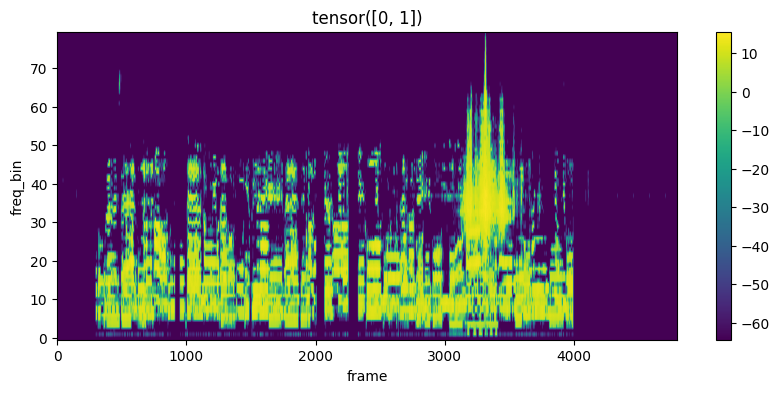

In [15]:
plot_spectrogram(augmentor.augment(copy.deepcopy( test ) ).squeeze(), str(train_dataset[0][1]))

### 모델 정의(resnet18)

In [16]:
def prepare_model():
    resnet_model = resnet18( weights='IMAGENET1K_V1' )
    resnet_model.fc = nn.Linear(512,2)

    for m in resnet_model.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
        elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)

    return resnet_model

In [17]:
#model = AudioModel(sr=config['sr'], n_mels = config['n_mels'], hidden_size = 40, num_output = 2)
model = prepare_model()
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 137MB/s]


In [18]:
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
criterion = nn.CrossEntropyLoss()

In [19]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()

def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)

def train(model, epoch, log_interval, train_loader=train_loader, path=model_save_path, loss_record=None):
    model.train()

    correct_train = 0
    for batch in train_loader:
        audio, label = batch

        data = audio.to(device)
        target = label.to(device)
        data = augmentor.augment(data)

        expanded_data = torch.stack([data]*3, dim=1)
        output = model(expanded_data)

        pred = get_likely_index(output)
        target = get_likely_index(target)
        correct_train += number_of_correct(pred, target)

        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        loss = criterion(output, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # update progress bar
        pbar.update(pbar_update)
        #save model
        if len(loss_record)>0:
            if min(loss_record) > loss.item():
                print("save mode at ", epoch)
                torch.save(model.state_dict(), path)
        # record loss
        loss_record.append(loss.item())

    print(f"\nTrain Epoch: {epoch}\tAccuracy: {correct_train}/{len(train_loader.dataset)} ({100. * correct_train / len(train_loader.dataset):.0f}%)\n")
    return (100. * correct_train / len(train_loader.dataset))

In [20]:
def valid(model, epoch, valid_loader=valid_loader):
    model.eval()
    correct = 0
    for data, target in valid_loader:

        data = data.to(device)
        target = target.to(device)

        expanded_data = torch.stack([data]*3, dim=1)
        output = model(expanded_data)

        pred = get_likely_index(output)
        target = get_likely_index(target)
        correct += number_of_correct(pred, target)

        # update progress bar
        pbar.update(pbar_update)

    print(f"\nValid Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n")
    return (100. * correct / len(test_loader.dataset))


In [21]:
log_interval = 20
n_epoch = 25

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []
train_accuracy = []
test_accuracy = []
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train_acc_per_epoch = train(model, epoch, log_interval, path=config['path'], loss_record=losses)
        test_acc_per_epoch = valid(model, epoch)
        scheduler.step()

        train_accuracy.append(train_acc_per_epoch)
        test_accuracy.append(test_acc_per_epoch)

  2%|▏         | 0.42857142857142855/25 [00:24<16:18, 39.84s/it]

save mode at  1


  3%|▎         | 0.7142857142857142/25 [00:25<07:02, 17.42s/it]

save mode at  1

Train Epoch: 1	Accuracy: 30/48 (62%)



  3%|▎         | 0.857142857142857/25 [00:34<12:46, 31.75s/it] 


Valid Epoch: 1	Accuracy: 9/16 (56%)



  5%|▌         | 1.2857142857142854/25 [00:43<09:44, 24.64s/it]

save mode at  2


  6%|▌         | 1.4285714285714282/25 [00:44<07:31, 19.15s/it]

save mode at  2


  7%|▋         | 1.7142857142857137/25 [00:45<04:32, 11.71s/it]


Train Epoch: 2	Accuracy: 40/48 (83%)



  7%|▋         | 1.8571428571428565/25 [00:54<10:25, 27.02s/it]


Valid Epoch: 2	Accuracy: 9/16 (56%)



 11%|█         | 2.7142857142857135/25 [01:04<03:54, 10.51s/it]


Train Epoch: 3	Accuracy: 38/48 (79%)



 11%|█▏        | 2.8571428571428563/25 [01:14<10:03, 27.25s/it]


Valid Epoch: 3	Accuracy: 9/16 (56%)



 15%|█▍        | 3.714285714285713/25 [01:24<03:45, 10.60s/it] 


Train Epoch: 4	Accuracy: 38/48 (79%)



 15%|█▌        | 3.857142857142856/25 [01:34<09:36, 27.27s/it]


Valid Epoch: 4	Accuracy: 9/16 (56%)



 19%|█▉        | 4.714285714285714/25 [01:46<03:51, 11.41s/it]


Train Epoch: 5	Accuracy: 41/48 (85%)



 19%|█▉        | 4.857142857142858/25 [01:54<08:29, 25.31s/it]


Valid Epoch: 5	Accuracy: 9/16 (56%)



 23%|██▎       | 5.714285714285717/25 [02:06<03:27, 10.74s/it]


Train Epoch: 6	Accuracy: 38/48 (79%)



 23%|██▎       | 5.85714285714286/25 [02:14<07:59, 25.02s/it] 


Valid Epoch: 6	Accuracy: 9/16 (56%)



 27%|██▋       | 6.71428571428572/25 [02:24<03:09, 10.37s/it]  

save mode at  7

Train Epoch: 7	Accuracy: 41/48 (85%)



 27%|██▋       | 6.857142857142863/25 [02:32<06:54, 22.86s/it]


Valid Epoch: 7	Accuracy: 10/16 (62%)



 31%|███       | 7.714285714285722/25 [02:44<03:06, 10.78s/it]


Train Epoch: 8	Accuracy: 40/48 (83%)



 31%|███▏      | 7.857142857142866/25 [02:52<06:44, 23.62s/it]


Valid Epoch: 8	Accuracy: 13/16 (81%)



 35%|███▍      | 8.71428571428572/25 [03:05<03:04, 11.34s/it] 


Train Epoch: 9	Accuracy: 43/48 (90%)



 35%|███▌      | 8.857142857142863/25 [03:13<06:24, 23.80s/it]


Valid Epoch: 9	Accuracy: 12/16 (75%)



 38%|███▊      | 9.571428571428575/25 [03:22<03:17, 12.81s/it]

save mode at  10


 39%|███▉      | 9.714285714285717/25 [03:23<02:36, 10.26s/it]


Train Epoch: 10	Accuracy: 41/48 (85%)



 39%|███▉      | 9.85714285714286/25 [03:31<05:58, 23.71s/it] 


Valid Epoch: 10	Accuracy: 13/16 (81%)



 43%|████▎     | 10.714285714285714/25 [03:41<02:29, 10.46s/it]


Train Epoch: 11	Accuracy: 40/48 (83%)



 43%|████▎     | 10.857142857142856/25 [03:50<05:52, 24.91s/it]


Valid Epoch: 11	Accuracy: 13/16 (81%)



 46%|████▌     | 11.428571428571425/25 [03:59<03:39, 16.20s/it]

save mode at  12


 47%|████▋     | 11.71428571428571/25 [04:00<02:15, 10.21s/it] 


Train Epoch: 12	Accuracy: 41/48 (85%)



 47%|████▋     | 11.857142857142852/25 [04:08<05:02, 22.99s/it]


Valid Epoch: 12	Accuracy: 12/16 (75%)



 51%|█████     | 12.714285714285706/25 [04:19<02:09, 10.50s/it]


Train Epoch: 13	Accuracy: 42/48 (88%)



 51%|█████▏    | 12.857142857142849/25 [04:28<05:19, 26.31s/it]


Valid Epoch: 13	Accuracy: 13/16 (81%)



 55%|█████▍    | 13.714285714285703/25 [04:38<01:56, 10.36s/it]


Train Epoch: 14	Accuracy: 42/48 (88%)



 55%|█████▌    | 13.857142857142845/25 [04:45<03:58, 21.41s/it]


Valid Epoch: 14	Accuracy: 14/16 (88%)



 59%|█████▉    | 14.7142857142857/25 [04:55<01:43, 10.04s/it]  


Train Epoch: 15	Accuracy: 41/48 (85%)



 59%|█████▉    | 14.857142857142842/25 [05:02<03:29, 20.68s/it]


Valid Epoch: 15	Accuracy: 14/16 (88%)



 63%|██████▎   | 15.714285714285696/25 [05:12<01:27,  9.48s/it]


Train Epoch: 16	Accuracy: 41/48 (85%)



 63%|██████▎   | 15.857142857142838/25 [05:20<03:22, 22.16s/it]


Valid Epoch: 16	Accuracy: 12/16 (75%)



 67%|██████▋   | 16.714285714285694/25 [05:29<01:23, 10.06s/it]


Train Epoch: 17	Accuracy: 41/48 (85%)



 67%|██████▋   | 16.857142857142836/25 [05:36<02:47, 20.58s/it]


Valid Epoch: 17	Accuracy: 12/16 (75%)



 71%|███████   | 17.71428571428569/25 [05:47<01:09,  9.60s/it] 


Train Epoch: 18	Accuracy: 41/48 (85%)



 71%|███████▏  | 17.857142857142833/25 [05:54<02:36, 21.88s/it]


Valid Epoch: 18	Accuracy: 11/16 (69%)



 75%|███████▍  | 18.714285714285687/25 [06:04<01:03, 10.03s/it]


Train Epoch: 19	Accuracy: 40/48 (83%)



 75%|███████▌  | 18.85714285714283/25 [06:11<02:02, 19.95s/it] 


Valid Epoch: 19	Accuracy: 13/16 (81%)



 79%|███████▉  | 19.714285714285683/25 [06:21<00:50,  9.59s/it]


Train Epoch: 20	Accuracy: 43/48 (90%)



 79%|███████▉  | 19.857142857142826/25 [06:29<01:57, 22.84s/it]


Valid Epoch: 20	Accuracy: 14/16 (88%)



 83%|████████▎ | 20.71428571428568/25 [06:40<00:43, 10.19s/it] 


Train Epoch: 21	Accuracy: 41/48 (85%)



 83%|████████▎ | 20.857142857142822/25 [06:47<01:30, 21.78s/it]


Valid Epoch: 21	Accuracy: 14/16 (88%)



 87%|████████▋ | 21.714285714285676/25 [06:57<00:32,  9.78s/it]


Train Epoch: 22	Accuracy: 43/48 (90%)



 87%|████████▋ | 21.85714285714282/25 [07:05<01:16, 24.35s/it] 


Valid Epoch: 22	Accuracy: 14/16 (88%)



 91%|█████████ | 22.714285714285673/25 [07:16<00:24, 10.62s/it]


Train Epoch: 23	Accuracy: 44/48 (92%)



 91%|█████████▏| 22.857142857142815/25 [07:23<00:47, 22.28s/it]


Valid Epoch: 23	Accuracy: 12/16 (75%)



 95%|█████████▍| 23.71428571428567/25 [07:32<00:11,  9.19s/it] 


Train Epoch: 24	Accuracy: 44/48 (92%)



 95%|█████████▌| 23.85714285714281/25 [07:38<00:20, 18.27s/it]


Valid Epoch: 24	Accuracy: 13/16 (81%)



 99%|█████████▉| 24.714285714285666/25 [07:50<00:02,  9.80s/it]


Train Epoch: 25	Accuracy: 43/48 (90%)



100%|█████████▉| 24.99999999999995/25 [07:57<00:00, 19.08s/it] 


Valid Epoch: 25	Accuracy: 13/16 (81%)



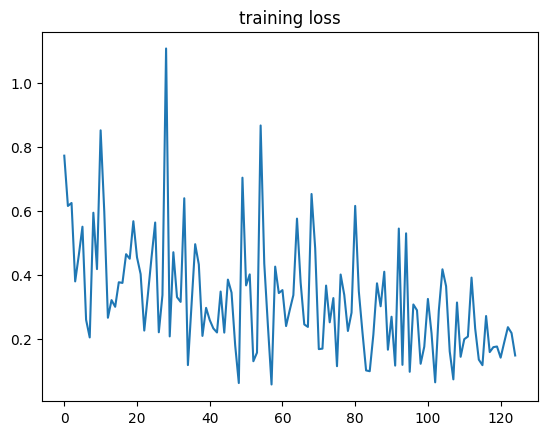

In [22]:
plt.plot(losses);
plt.title("training loss");

<Figure size 640x480 with 0 Axes>

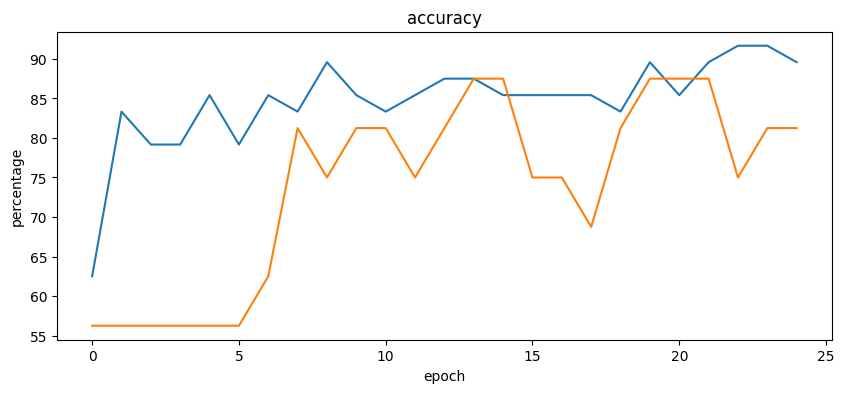

In [23]:
plt.clf()
fig, axs = plt.subplots(1, 1, figsize=(10, 4))
axs.set_title("accuracy")
axs.set_xlabel("epoch")
axs.set_ylabel("percentage")
axs.plot(train_accuracy, label="train_acc")
axs.plot(test_accuracy, label="test_acc")

In [24]:
def test(model_path):

    #model = AudioModel(sr=config['sr'], n_mels = config['n_mels'], hidden_size = 40, num_output = 2)
    model = prepare_model()
    model.load_state_dict(torch.load(model_path))
    model.to(config['device'])
    model.eval()
    correct = 0
    for data, target in test_loader:

        data = data.to(device)
        target = target.to(device)

        expanded_data = torch.stack([data]*3, dim=1)
        output = model(expanded_data)

        pred = get_likely_index(output)
        target = get_likely_index(target)
        correct += number_of_correct(pred, target)

    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n")

In [25]:
test(config['path'])


Test Epoch: 25	Accuracy: 12/16 (75%)



# Inference

In [26]:
!pip install speechbrain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 553.8/553.8 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 73.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.9/112.9 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.7/526.7 kB 51.6 MB/s eta 0:00:00


In [27]:
def get_other_sound():
    # 병합할 다른 소리 파일 가져오기
        _meta = pd.read_csv( othersourcePath + "/meta.csv", index_col=[0] )

        _meta = _meta['mp3_path']
        path = _meta.iloc[random.randrange(1,len(_meta))]

        waveform, sample_rate = torchaudio.load( othersourcePath / Path(str(path)).with_suffix('.mp3'))
        audio_sample = F.resample(waveform[0], sample_rate, config['sr'], lowpass_filter_width=6)
        return audio_sample

def minmaxScaler(data):
    # 정규화 수행
        data_min, data_max = data.min(), data.max()
        new_lower, new_upper = -1, 1
        scaled_data = (data - data_min)/(data_max - data_min)*(new_upper - new_lower) + new_lower
        return scaled_data

def mixOtherSound(audio_sample, mix_rate=1.0):
    # 시험 데이터를 실 데이터로 전이시키는 함수
        other_sound = get_other_sound()
        if len(other_sound) > len(audio_sample):
            other_sound = other_sound[:len(audio_sample)]
        else:
            other_sound = other_sound[:len(audio_sample)]
            front = int( (len(audio_sample) - len(other_sound)) / 4 ) * 3
            back = (len(audio_sample) - len(other_sound)) - front
            other_sound = nn.functional.pad(other_sound, (front, back) , 'constant', value=0)

        scaled_audio_data = minmaxScaler(audio_sample)
        scaled_other_data = minmaxScaler(other_sound)

        audio_sample = scaled_audio_data + (scaled_other_data*mix_rate)

        return audio_sample

In [28]:
path = "221109_hydrogen_S206_Num_1_Horn_Yes_2_22.wav"
waveform, sample_rate = torchaudio.load( dirPath / Path(path).with_suffix('.wav'))
audio_sample = F.resample(waveform[0], sample_rate, config['sr'], lowpass_filter_width=6)

audio_sample = mixOtherSound(audio_sample, mix_rate=0.2)

noisy_path = "./noisy_audio.wav"
torchaudio.save(noisy_path, audio_sample.unsqueeze(0), config['sr'])

In [29]:
from speechbrain.pretrained import SepformerSeparation as separator

In [30]:
#model = AudioModel(sr=config['sr'], n_mels = config['n_mels'], hidden_size = 40, num_output = 2)
#yes가 1임
waveform, sample_rate = torchaudio.load( dirPath / Path(path).with_suffix('.wav'))
audio_sample = F.resample(waveform[0], sample_rate, config['sr'], lowpass_filter_width=6)

mel_converter = torchaudio.transforms.MelSpectrogram(sample_rate=config['sr'], n_mels=config['n_mels'])
db_converter = torchaudio.transforms.AmplitudeToDB()

feature = db_converter(mel_converter(audio_sample))

model = prepare_model()
model.load_state_dict(torch.load(config['path']))
model.to(config['device'])
model.eval()

feature = feature.unsqueeze(0)
expanded_data = torch.stack([feature]*3, dim=1)
expanded_data = expanded_data.to(config['device'])
output = model(expanded_data)
pred = get_likely_index(output)

/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (80) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [31]:
print( "이상치 감지" if int(pred[0]) == 1 else "이상치 불검출")

이상치 감지


In [32]:
# clean_waveform_2, sample_rate = torchaudio.load( "./source2hat.wav" )
# audio_sample_2 = F.resample(clean_waveform_2[0], 16000, config['sr'], lowpass_filter_width=6)
# plt.plot(audio_sample_2)

In [33]:
# path = "221102_hydrogen_S206_Num_0_Horn_Yes_2_22.wav"
# waveform_origin, sample_rate = torchaudio.load( dirPath / Path(path).with_suffix('.wav'))
# audio_sample_origin = F.resample(waveform_origin[0], sample_rate, config['sr'], lowpass_filter_width=6)
# plt.plot(audio_sample_origin)

In [34]:
# noisy_path = "./noisy_audio.wav"
# waveform_noisy, sample_rate = torchaudio.load( Path(noisy_path).with_suffix('.wav'))
# audio_sample_noisy = F.resample(waveform_noisy[0], sample_rate, config['sr'], lowpass_filter_width=6)
# plt.title("Noisy")
# plt.plot(audio_sample_noisy)

In [35]:
#!cp /content/best_model.pt /content/drive/MyDrive/Artificial_Intelligence/ai_data/기차대차소음

# 예비 코드

In [36]:
def SoundAugment():
    def __init__(self, other_sound_path=None):
        assert other_sound_path is not None, "it must be filled"
        self.other_sound_dir = other_sound_path

    def _get_other_sound(self, sound, amplitude):
        _meta = pd.read_csv( self.other_sound_dir + "/meta.csv", index_col=[0] )

        _meta = _meta['mp3_path']
        path = _meta.iloc[random.randrange(1,len(_meta))]

        waveform, sample_rate = torchaudio.load( self.other_sound_dir / Path(str(path)).with_suffix('.mp3'))
        audio_sample = F.resample(waveform[0], sample_rate, self.config['sr'], lowpass_filter_width=6)
        augmented_sound = sound + audio_sample
        return augmented_sound

    def augment(self, feature):
        feature = self._get_other_sound(feature)
        return feature

In [37]:
def prepare_model():
    resnet_model = resnet18(weights='IMAGENET1K_V1')
    resnet_model.fc = nn.Linear(512,1)

    for m in resnet_model.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
        elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)

    return resnet_model

In [38]:
class AudioModel(nn.Module):
    def __init__(self, sr, n_mels, hidden_size, num_output, augmentation=False):
        super().__init__()
        self.sr = sr
        self.conv_layer = nn.Sequential(
          nn.Conv1d(n_mels, out_channels=hidden_size, kernel_size=2),
          nn.MaxPool1d(3),
          nn.ReLU(),
          nn.Conv1d(hidden_size, out_channels=hidden_size, kernel_size=3),
          nn.MaxPool1d(3),
          nn.ReLU(),
        )
        self.final_layer = nn.Linear(hidden_size, num_output)

    def forward(self, x):
        out = self.conv_layer(x)
        out = torch.max(out, dim=-1)[0]
        out = self.final_layer(out)
        out = torch.sigmoid(out)
        return out